In [142]:
#################################################################
## Foresight deep learning challenge 2021                      ##
## author: Vered Silverman                                     ###
## Diparity maps using RAFT
## based on demo.py from https://github.com/princeton-vl/RAFT
##################################################################
import sys
sys.path.append('RAFT/core')

import argparse
import os
import cv2 as cv
import glob
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
from raft import RAFT
from utils import flow_viz
from utils.utils import InputPadder


def load_image(imfile):
    # load image to be fed into the NN 
    img = Image.open(imfile)
    img = img.convert("RGB")
    img = np.array(img).astype(np.uint8)
    img = torch.from_numpy(img).permute(2, 0, 1).float()
    return img[None].to(DEVICE)


def my_viz(img, flo, img_gt):
    # visualize results with left image
    img = img[0].permute(1,2,0).cpu().numpy()
    flo = flo[0].permute(1,2,0).cpu().numpy()
    img_flo = flow_viz.flow_to_image(flo)
    img_flo = cv.cvtColor(img_flo, cv.COLOR_BGR2GRAY)
    img_flo = np.abs(img_flo-255)
    img_flo = cv.normalize(img_flo, None, 0, 255, cv.NORM_MINMAX)
    fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (10,15))

    iax = 0
    axes[iax].imshow(img/255)
    axes[iax].set_title('Left')
    
    iax += 1
    axes[iax].imshow(img_flo, 'gray_r')
    axes[iax].set_title('Flow')
 https://github.com/princeton-vl/RAFT

    return fig, img_flo



In [144]:
# set parameters for running the raft-sintel model in evaluation mode
modelname = 'raft-sintel'
parser = argparse.ArgumentParser()
parser.add_argument('--model', help="restore checkpoint")
parser.add_argument('--path', help="dataset for evaluation")
parser.add_argument('--small', action='store_true', help='use small model')
parser.add_argument('--mixed_precision', action='store_true', help='use mixed precision')
parser.add_argument('--alternate_corr', action='store_true', help='use efficent correlation implementation')
args = parser.parse_args(['--model', "RAFT/models/%s.pth"%(modelname), '--path', 'framesRAW'])

model = torch.nn.DataParallel(RAFT(args));
model.load_state_dict(torch.load(args.model));
model.cuda();
model = model.module
model.eval()

/work/silverv/anaconda3/envs/raft/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide


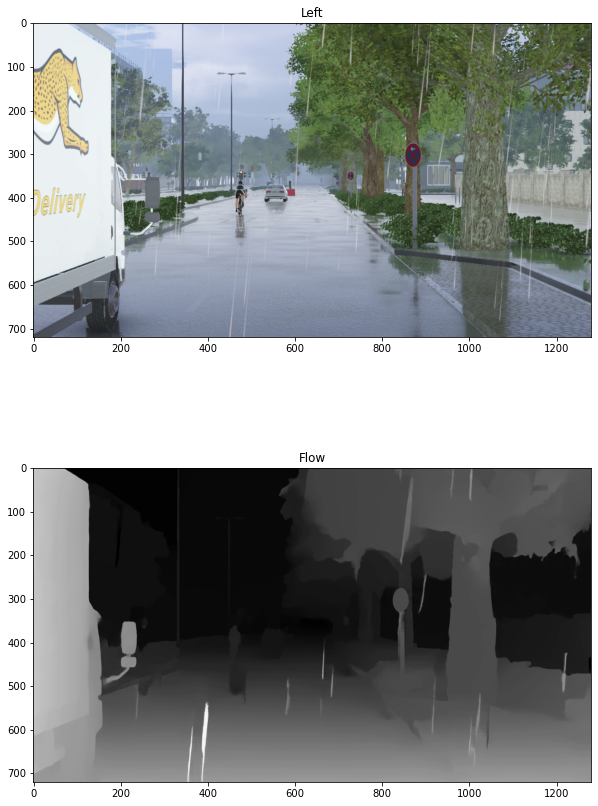

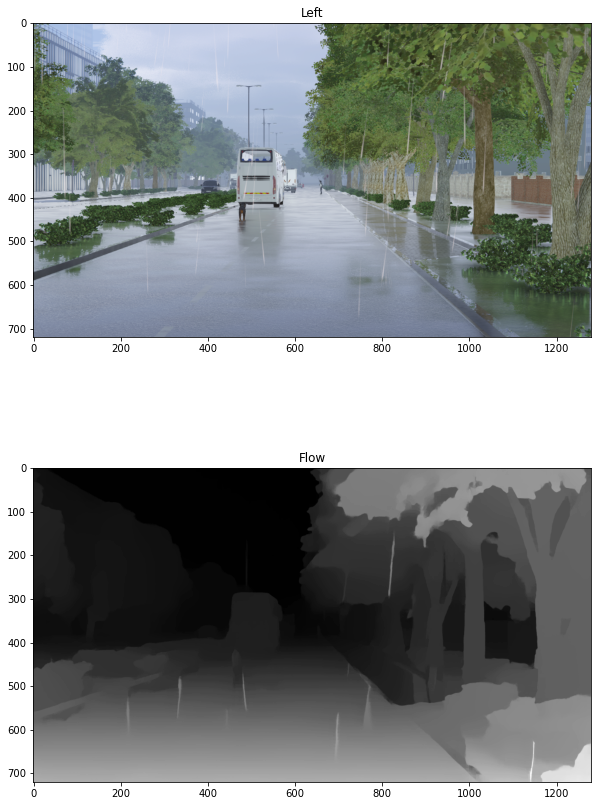

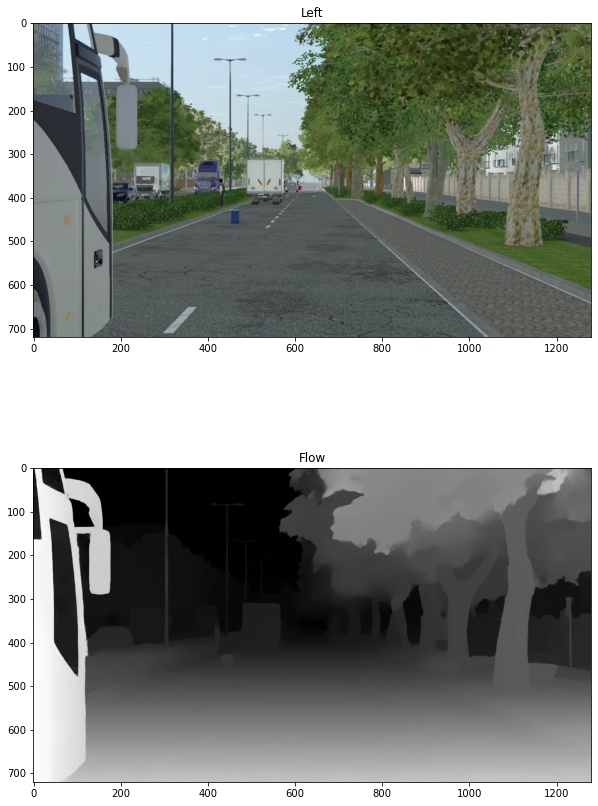

In [146]:
# get image paths and generate disparity maps for all three pairs
images = glob.glob(os.path.join(args.path, 'VL_left_*.png'))
    
with torch.no_grad():
    for imfile1 in images:
        imfile2 = imfile1.replace("left", "right")
        image1 = load_image(imfile1)
        image2 = load_image(imfile2)
        img_suffx = imfile1.split('_')[-1].split('.png')[0]
        padder = InputPadder(image1.shape)
        image1, image2 = padder.pad(image1, image2)
            
        flow_low, flow_up = model(image2, image1, iters=30, test_mode=True)
        # flow_https://github.com/princeton-vl/RAFTlow is coords2-coords1 at lower res, C, H, W
            
        flow_up_save = flow_up.cpu().numpy()[0,:,:,:]
        np.save('disparity_%s_img%s.npy'%(modelname, img_suffx), flow_up_save)
        
        dist = cv.imread(os.path.join(args.path,'dist_%s.png'%(img_suffx)), cv.IMREAD_UNCHANGED)
        inv_dist = 1/(dist)
        
        # use only horizxontal component
        flow_up_horiz = flow_up*1
        flow_up_horiz[:,1,:,:] = 0
        fig, img_flo = my_viz(image1, flow_up_horiz, inv_dist)
        fig.savefig('resultsHW/%s_LRHRGT_VL_horiz_%s'%(modelname, imfile1[18:]), dpi=100)